# Book Reccomendation 

## Data Preparation 
Here we download training and test data and load them into pandas DataFrames. 

In [1]:
import pandas as pd
import gzip

# Load training interactions

with gzip.open('data/train_Interactions.csv.gz', 'rt', encoding='utf-8') as f:
    interactions = pd.read_csv(f)

print(interactions.head())

      userID     bookID  rating
0  u67805239  b61372131       4
1  u54531895  b75189008       4
2  u76549666  b75446982       4
3  u03186275  b23482469       2
4  u21322233  b09979253       3


In [2]:
# Load training categories

# Function to parse the gzipped file
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

# Collect all data into a list
data = []
for d in parse('data/train_Category.json.gz'):
    data.append(d)

# Convert list to DataFrame
categories = pd.DataFrame(data)

# Display the DataFrame
print(categories.head())

     user_id  review_id  rating  \
0  u75242413  r45843137       4   
1  u72358746  r38427923       2   
2  u55827211  r97393610       5   
3  u15021470  r76296012       4   
4  u37264352  r09884372       4   

                                         review_text  n_votes  \
0  a clever book with a deeply troubling premise ...        1   
1  A little too much retconning for me, to be hon...        0   
2  So glad I finally got around to reading this b...        0   
3  I would classify this more as erotic paranorma...        0   
4  Loved it! So very Butcher, although I still th...        0   

                    genre  genreID  
0  mystery_thriller_crime        3  
1          comics_graphic        1  
2             young_adult        4  
3      fantasy_paranormal        2  
4      fantasy_paranormal        2  


## Exploratory Data Analysis (EDA)
Here, we perform EDA to understand the data distribution, identify missing values, and visualize key statistics.

              rating
count  200000.000000
mean        3.687005
std         1.318529
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


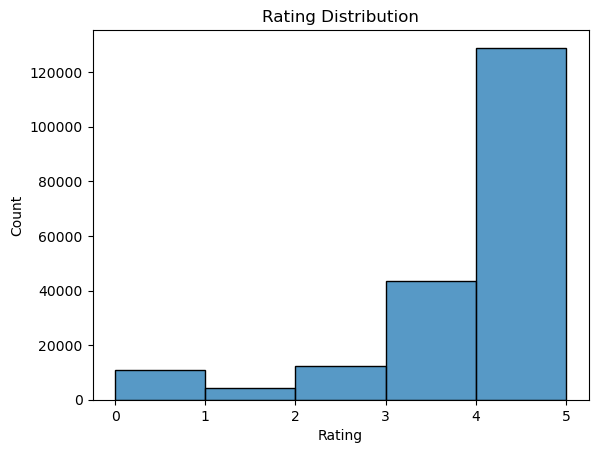

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


              rating       n_votes        genreID
count  100000.000000  100000.00000  100000.000000
mean        3.796010       1.25419       2.423300
std         1.165844       8.51403       1.154275
min         0.000000      -3.00000       0.000000
25%         3.000000       0.00000       2.000000
50%         4.000000       0.00000       2.000000
75%         5.000000       1.00000       3.000000
max         5.000000    1150.00000       4.000000


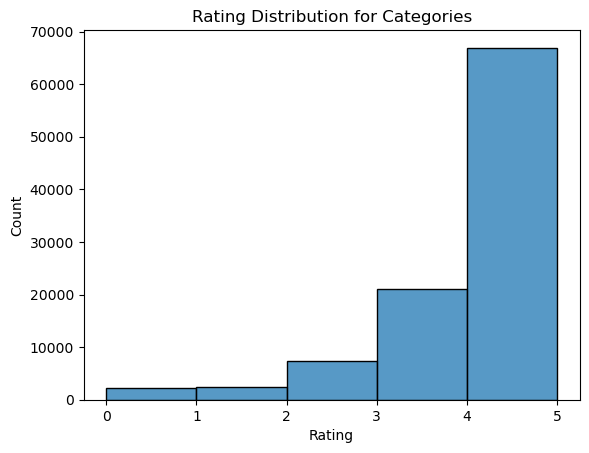

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA for interactions
print(interactions.describe())
sns.histplot(interactions['rating'], bins=5, kde=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# EDA for categories
print(categories.describe())
sns.histplot(categories['rating'], bins=5, kde=False)
plt.title('Rating Distribution for Categories')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

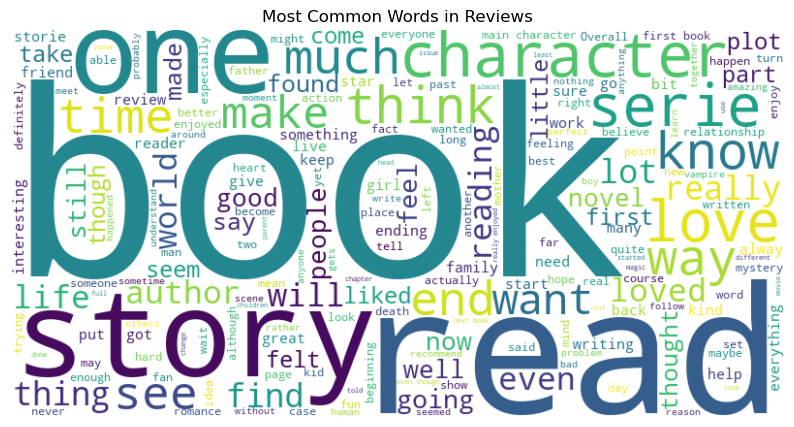

In [4]:
from wordcloud import WordCloud

# Combine all review texts
all_reviews = ' '.join(categories['review_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()

## Data Preprocessing 

Here, we preprocess the data for modeling tasks such as feature extraction, text cleaning, and handling missing values.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Text preprocessing for review text
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf.fit_transform(categories['review_text'])

# Combine interaction and category data for the read prediction task
data = pd.merge(interactions, categories, how='inner', left_on=['userID', 'bookID'], right_on=['user_id', 'review_id'])

## Read Prediction
We will do a training/test split since we don't have access to test interactions, with reviews 1-190,000 for training and 190,001-200,000 for validation. 

In [6]:
# Split the data into training and validation sets based on indices
train_data = interactions.iloc[:190000]
validation_data_raw = interactions.iloc[190000:200000]

1. Create Validation set with negative samples: 
* For each (user, book) entry in the validation set, we need to sample a negative entry by randomly choosing a book that the user hasn't read. 

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Create validation set with positive and negative samples
def create_validation_set(data, negative_ratio=1):
    # Group by user and collect read books
    user_books = data.groupby('userID')['bookID'].apply(set).reset_index()
    
    # All unique books
    all_books = set(data['bookID'])
    
    validation_set = []
    
    for idx, row in user_books.iterrows():
        user, read_books = row['userID'], row['bookID']
        unread_books = list(all_books - read_books)
        
        # Sample negative examples
        negative_samples = np.random.choice(unread_books, size=min(len(read_books) * negative_ratio, len(unread_books)), replace=False)
        
        # Add negative samples
        validation_set.extend([[user, book, 0] for book in negative_samples])
        
        # Add positive samples
        validation_set.extend([[user, book, 1] for book in read_books])
    
    return pd.DataFrame(validation_set, columns=['userID', 'bookID', 'read'])


validation_data = create_validation_set(validation_data_raw)

# Display the validation DataFrame
print(validation_data.head())
print(type(validation_data))

      userID     bookID  read
0  u00000114  b60783224     0
1  u00000114  b19867465     1
2  u00012433  b17581033     0
3  u00012433  b62008180     1
4  u00015114  b28801125     0
<class 'pandas.core.frame.DataFrame'>


2. Baseline Model Evaluation:
* Evaluate the performance (accuracy) of the baseline model on the validation set.

In [8]:
# Baseline model based on popularity
def baseline_model(data, threshold):
    book_counts = data['bookID'].value_counts()
    popular_books = book_counts[book_counts >= threshold].index
    data['predicted'] = data['bookID'].isin(popular_books).astype(int)
    return data, popular_books


# Define the threshold for popularity based on the training set
threshold = train_data['bookID'].value_counts().quantile(0.5)
# Apply baseline model on validation set
validation_data,popular_books = baseline_model(validation_data, threshold)


# Calculate accuracy
accuracy = (validation_data['read'] == validation_data['predicted']).mean()
print(f'Baseline Model Accuracy: {accuracy}')

Baseline Model Accuracy: 0.6429


3. Threshold Optimization
* The baseline model just returns True that a user has read this book if the item in question is "popular," using a threshold based on the books which have 50% of all user interactions `(totalRead/2)`. Here we will find a better threshold for the popularity-based model and report the performance on the validation set. 

In [9]:
best_accuracy = 0
best_threshold = 0

# Calculate the best threshold using quantiles
for q in np.linspace(0.1, 0.9, 9):
    threshold = interactions['bookID'].value_counts().quantile(q)
    validation_data, popular_books = baseline_model(validation_data.copy(), threshold)
    accuracy = (validation_data['read'] == validation_data['predicted']).mean()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best Accuracy: {best_accuracy}')

# Apply best threshold on baseline model on validation set
validation_data, popular_books = baseline_model(validation_data, best_threshold)

Best Threshold: 11.0
Best Accuracy: 0.6431


4. Jaccard Similarity Model 
* We will implement a model using a Jaccard similarity and evaluate its performance on the validation set. 

In [10]:
from collections import defaultdict

# Precompute user-books and book-users sets
user_books = defaultdict(set)
book_users = defaultdict(set)

for idx, row in train_data.iterrows():
    user_books[row['userID']].add(row['bookID'])
    book_users[row['bookID']].add(row['userID'])

# Function to calculate Jaccard similarity between two sets
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

# Optimized function to calculate Jaccard similarity
def jaccard_similarity(user, book):
    user_books_set = user_books[user]
    book_users_set = book_users[book]
    similarities = []
    for ub in user_books_set:
        ub_users_set = book_users[ub]
        similarity = Jaccard(book_users_set, ub_users_set)
        similarities.append(similarity)
    return max(similarities) if similarities else 0

# Predict using Jaccard similarity
validation_data['jaccard'] = validation_data.apply(lambda row: jaccard_similarity(row['userID'], row['bookID']), axis=1)

# Define and test different Jaccard thresholds
jaccard_thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]
for threshold in jaccard_thresholds:
    validation_data['predicted'] = (validation_data['jaccard'] > threshold).astype(int)
    accuracy = (validation_data['read'] == validation_data['predicted']).mean()
    print(f'Jaccard Threshold: {threshold}, Model Accuracy: {accuracy}')

Jaccard Threshold: 0.01, Model Accuracy: 0.5746
Jaccard Threshold: 0.05, Model Accuracy: 0.5001
Jaccard Threshold: 0.1, Model Accuracy: 0.4988
Jaccard Threshold: 0.2, Model Accuracy: 0.4986
Jaccard Threshold: 0.3, Model Accuracy: 0.4986


In [11]:
# Choose the best threshold for the final accuracy

jaccard_threshold = 0.01
validation_data['predicted'] = (validation_data['jaccard'] > jaccard_threshold).astype(int)

# Calculate final accuracy
accuracy = (validation_data['read'] == validation_data['predicted']).mean()
print(f'Final Jaccard Similarity Model Accuracy: {accuracy}')

Final Jaccard Similarity Model Accuracy: 0.5746


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create additional features
train_data['user_interactions'] = train_data.groupby('userID')['userID'].transform('count')
train_data['book_interactions'] = train_data.groupby('bookID')['bookID'].transform('count')
train_data['user_avg_rating'] = train_data.groupby('userID')['rating'].transform('mean')
train_data['book_avg_rating'] = train_data.groupby('bookID')['rating'].transform('mean')

# Drop the original rating column and any other unnecessary columns
X = train_data.drop(columns=['userID', 'bookID', 'rating'])
y = (train_data['rating'] > 0).astype(int)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

/var/folders/w7/81ccg5dn6gj_k38yphlwqckr0000gp/T/ipykernel_20963/2774900963.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['user_interactions'] = train_data.groupby('userID')['userID'].transform('count')
/var/folders/w7/81ccg5dn6gj_k38yphlwqckr0000gp/T/ipykernel_20963/2774900963.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['book_interactions'] = train_data.groupby('bookID')['bookID'].transform('count')
/var/folders/w7/81ccg5dn6gj_k38yphlwqckr0000gp/T/ipykernel_20963/2774900

5. Hybrid Model:
* Here we will combine Jaccard-based threshold and popularity-based threshold to improve prediction accuracy.

In [13]:
# Define the hybrid model function
def hybrid_model(row, popular_books, jaccard_threshold):
    is_popular = row['bookID'] in popular_books
    is_similar = row['jaccard'] > jaccard_threshold
    return is_popular or is_similar

# Predict using the hybrid model
validation_data['predicted'] = validation_data.apply(hybrid_model, args=(popular_books, jaccard_threshold), axis=1)

# Calculate accuracy
accuracy = (validation_data['read'] == validation_data['predicted']).mean()
print(f'Hybrid Model Accuracy: {accuracy}') #around 0.65

Hybrid Model Accuracy: 0.65565


6. Neural Network Model
* Here we use a Neural Network Model in order to improve Accuracy in read predictions


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model on validation data
loss, accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Neural Network Model Accuracy on Validation Data: {accuracy}')

# Predict on validation data
y_val_pred = model.predict(X_val_scaled)
y_val_pred_classes = (y_val_pred > 0.5).astype(int)

# Calculate accuracy
validation_accuracy = accuracy_score(y_val, y_val_pred_classes)
print(f'Validation Accuracy: {validation_accuracy}') #around 0.95

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4750/4750 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step - accuracy: 0.9487 - loss: 0.1790 - val_accuracy: 0.9544 - val_loss: 0.1468
Epoch 2/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step - accuracy: 0.9535 - loss: 0.1516 - val_accuracy: 0.9540 - val_loss: 0.1464
Epoch 3/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step - accuracy: 0.9543 - loss: 0.1484 - val_accuracy: 0.9541 - val_loss: 0.1461
Epoch 4/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - accuracy: 0.9540 - loss: 0.1498 - val_accuracy: 0.9541 - val_loss: 0.1461
Epoch 5/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 421us/step - accuracy: 0.9545 - loss: 0.1493 - val_accuracy: 0.9547 - val_loss: 0.1463
Epoch 6/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 442us/step - accuracy: 0.9542 - loss: 0.1483 - val_accuracy: 0.9542 - val_loss: 0.1465
Epoch 7/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 423us/step - accuracy: 0.9542 - loss: 0.1483 - val_accuracy: 0.9542 - val_loss: 0.1458
Epoch 8/10
4750/4750 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - accuracy: 0.9541 - loss: 0.14

## Model Deployment

Use the final model to make predictions on the test set (`pairs_Read.csv`).

In [15]:

# Load test set
test_pairs = pd.read_csv('data/pairs_Read.csv')



# Add jaccard similarity column
test_pairs['jaccard'] = test_pairs.apply(lambda row: jaccard_similarity(row['userID'], row['bookID']), axis=1)

# Make predictions
test_pairs['prediction'] = test_pairs.apply(hybrid_model, args=(popular_books, jaccard_threshold), axis=1)

# Save predictions
test_pairs.to_csv('data/predictions.csv', index=False)

## Category Prediction

In [16]:
# Import necessary libraries
import gzip
import math
import matplotlib.pyplot as plt
import numpy
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn import linear_model
from sklearn.manifold import TSNE
import gzip

In [17]:
# Function to read a gzipped JSON file line by line and yield each line as a Python dictionary
def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

# Function to read a gzipped CSV file line by line, skipping the header, and yield each line as a list of values
def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')


In [18]:
# Mapping of book categories to integer IDs
catDict = {
  "children": 0,
  "comics_graphic": 1,
  "fantasy_paranormal": 2,
  "mystery_thriller_crime": 3,
  "young_adult": 4
}

# Prepare to write predictions for the Category model into a CSV file
predictions = open("data/predictions_Category.csv", 'w')
predictions.write("userID,reviewID,prediction\n")

27

In [19]:
# Read in the training data for the Category prediction model
catData = []
for l in readGz("data/train_Category.json.gz"):
    catData.append(l)

# Set of common English stop words to remove from the review text
stop_words = set(stopwords.words('english'))

In [20]:
# Count the frequency of each word in the reviews, excluding stop words and punctuation
wordCount = defaultdict(int)
punctuation = set(string.punctuation)

for d in catData:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  for w in r.split() :
    if(w not in stop_words):
      wordCount[w] += 1
    
len(wordCount)

285643

In [21]:
# Sort the words by their frequency in descending order
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [22]:
# Select the top 10,000 most frequent words as the features for the model
NW = 10000 # dictionary size

words = [x[1] for x in counts[:NW]]

# Create a mapping from words to their feature indices
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

# Function to convert a review into a feature vector based on the selected words
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w in wordSet:
            feat[wordId[w]] += 1
    feat.append(1) # add offset term for linear regression
    return feat

# Create feature vectors for each review in the training data and their corresponding genre labels
X = [feature(d) for d in catData]
y = [d['genreID'] for d in catData]

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the training set
mod = linear_model.LogisticRegression(C=0.1)
mod.fit(X_train, y_train)

# Predict the genre labels for the validation set
y_valid_pred = mod.predict(X_valid)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.7394


In [23]:
# Read in the test data for Category prediction
data_test = []

for d in readGz("data/test_Category.json.gz"):
    data_test.append(d)

# Create feature vectors for the test data
Xtest = [feature(d) for d in data_test]

# Use the trained model to predict the genre for each review in the test data
pred_test = mod.predict(Xtest)

In [24]:
# Write predictions to the output CSV file
predictions = open("data/predictions_Category.csv", 'w')
pos = 0

for l in open("data/pairs_Category.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,b = l.strip().split(',')
    _ = predictions.write(u + ',' + b + ',' + str(pred_test[pos]) + '\n')
    pos += 1

predictions.close()

## Rating Prediction 

1. Build training/validation sets: 
* We create training and validation sets from `train_Interactions.csv.gz`. 

In [25]:
# Split the data
train_interactions, val_interactions = train_test_split(interactions, test_size=0.1, random_state=42)

2. Fit Bias Model:
* We will fit a predictor of the form: 
$rating(user, item) ≃ \alpha + \beta user + \beta item$

In [26]:
# Fit bias model
global_mean = train_interactions['rating'].mean()
user_bias = train_interactions.groupby('userID')['rating'].mean() - global_mean
item_bias = train_interactions.groupby('bookID')['rating'].mean() - global_mean

def predict_rating(user, item):
    return global_mean + user_bias.get(user, 0) + item_bias.get(item, 0)

# Evaluate on validation set
val_interactions['predicted'] = val_interactions.apply(lambda row: predict_rating(row['userID'], row['bookID']), axis=1)
mse = ((val_interactions['rating'] - val_interactions['predicted']) ** 2).mean()
print(f'Baseline Model MSE: {mse}')

Baseline Model MSE: 1.6202596654692452


3. Optimize regularization parameter 
* We try to find a better value for the regularization parameter, $\lambda$

In [27]:
# Optimize regularization parameter
best_lambda = 1
best_mse = mse

for lambda_ in [0.1, 1, 10]:
    user_bias = (train_interactions.groupby('userID')['rating'].sum() - lambda_ * global_mean) / (train_interactions.groupby('userID')['rating'].count() + lambda_)
    item_bias = (train_interactions.groupby('bookID')['rating'].sum() - lambda_ * global_mean) / (train_interactions.groupby('bookID')['rating'].count() + lambda_)

    val_interactions['predicted'] = val_interactions.apply(lambda row: predict_rating(row['userID'], row['bookID']), axis=1)
    mse = ((val_interactions['rating'] - val_interactions['predicted']) ** 2).mean()
    if mse < best_mse:
        best_mse = mse
        best_lambda = lambda_

print(f'Optimized Lambda: {best_lambda}')
print(f'Optimized Model MSE: {best_mse}')

Optimized Lambda: 1
Optimized Model MSE: 1.6202596654692452


Since the ratings are on a scale of 1 to 5, an MSE of 1.62 might indicate that the predictions are off by about 1.27 rating points on average, as:

$\text{RMSE} = \sqrt{1.62} \approx 1.27$


4. Deploy Model:
* Use the final model to make predictions on the test set `pairs_Rating.csv`.

In [28]:
# Load test set
test_pairs = pd.read_csv('data/pairs_Rating.csv')

# Make predictions
test_pairs['predicted'] = test_pairs.apply(lambda row: predict_rating(row['userID'], row['bookID']), axis=1)

# Save predictions
test_pairs.to_csv('data/rating_predictions.csv', index=False)